In [1]:
from dataset import DomainDataset
from torch.utils.data import DataLoader 
from model import MYCNDistinguisher
import torch
from tqdm import tqdm
from FISHClass.utils.device import best_gpu
import numpy as np
import matplotlib.pyplot as plt
from FISHClass.utils.visualize import gridPlot

In [2]:
ds = DomainDataset("/home/simon_g/src/DomainAdapt/dm_set.h5")

In [3]:
dl = DataLoader(ds, shuffle=True, batch_size=256)

In [4]:
model = MYCNDistinguisher(layers=[3, 16, 32, 64])

loss = torch.nn.BCEWithLogitsLoss()

optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

device = best_gpu()
model.to(device)

for epoch in range(10):
    cumm_l = 0 
    with tqdm(dl) as train_loop:

        for X, y, i in train_loop:

            ŷ = model(X.to(device)).float()
            l = loss(ŷ, y.float().to(device))
            optim.zero_grad()
            l.backward()
            optim.step()
            cumm_l += l.item()/X.shape[0]
            
            train_loop.set_postfix({"loss": cumm_l})
            

100%|██████████| 59/59 [00:11<00:00,  4.92it/s, loss=0.00747]


In [5]:
device = best_gpu()
model.to(device)
model.eval()

ys, preds, ids = [], [], []
for X, y, i in tqdm(dl):
    ys.extend(y.numpy())
    X = X.to(device)
    preds.extend(model(X).detach().cpu().numpy())
    ids.extend(i)

100%|██████████| 59/59 [00:05<00:00,  9.92it/s]


In [6]:
preds = np.array(preds)
ids = np.array(ids)
ys = np.array(ys)

print(preds.shape, ids.shape)

(15000,) (15000,)


In [7]:
res = preds > 0

In [8]:
(res == ys).sum() / len(ys)

0.9824

In [9]:
fs = []
def get_info(self, input, output):
    
    fs.extend(output.detach().cpu().numpy().reshape(output.shape[0], -1))
    
hook = model.downs[-1].register_forward_hook(get_info)

In [10]:
device = best_gpu()
model.to(device)
model.eval()

orig, preds, ids, ys = [], [], [], []
for X, y, i in tqdm(dl):
    orig.extend(X.numpy().transpose(0,2,3,1))
    X = X.to(device)
    preds.extend(model(X).detach().cpu().numpy())
    ids.extend(i.numpy())
    ys.extend(y.numpy())

100%|██████████| 59/59 [00:06<00:00,  9.51it/s]


In [11]:
hook.remove()

In [12]:
fs = np.stack(fs, axis=0)
ids = np.array(ids)
ys = np.array(ys)

print(fs.shape)

(15000, 16384)


In [13]:
import pandas as pd
import numpy as np
import umap

mapper = umap.UMAP().fit(fs)
emb = mapper.transform(fs)

from umap.parametric_umap import ParametricUMAP

#mapper = ParametricUMAP().fit(fs)

2022-11-29 14:24:35.243394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/BB/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-29 14:24:35.243422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
#emb = mapper.transform(fs)

hover_data = pd.DataFrame({'index': np.arange(fs.shape[0]),
                           'label': ys,
                           'sample_id': ids,
                           'x': emb[:,0],
                           'y': emb[:,1]})

In [32]:
import umap.plot

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, hover_data=hover_data, point_size=5, labels=ys)
#p.star(test_pts[:,0], test_pts[:,1], size=20, color="black")
umap.plot.show(p)

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, hover_data=hover_data, point_size=5, labels=ids)
#p.star(test_pts[:,0], test_pts[:,1], size=20, color="black")
umap.plot.show(p)

Loading BokehJS ...

Loading BokehJS ...

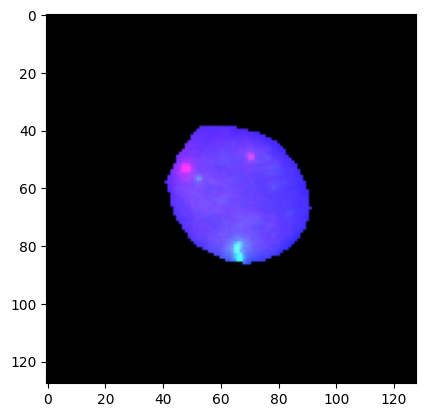

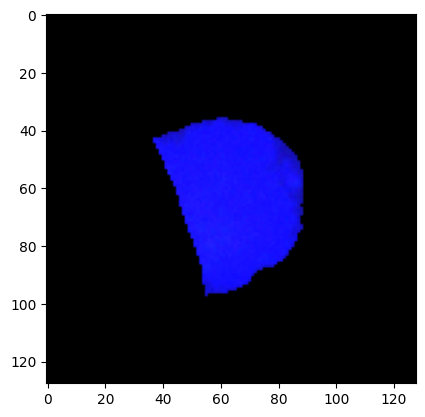

In [36]:
plt.imshow(orig[13806])
plt.show()
plt.imshow(orig[9427])
plt.show()

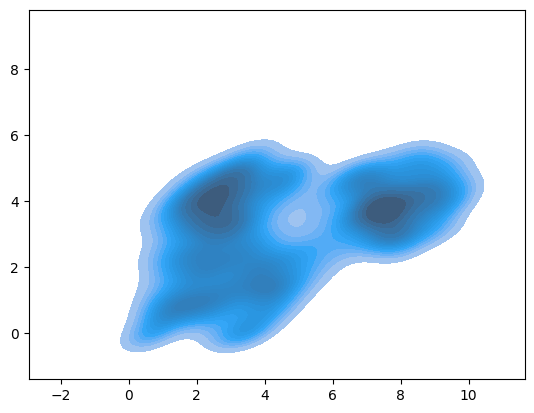

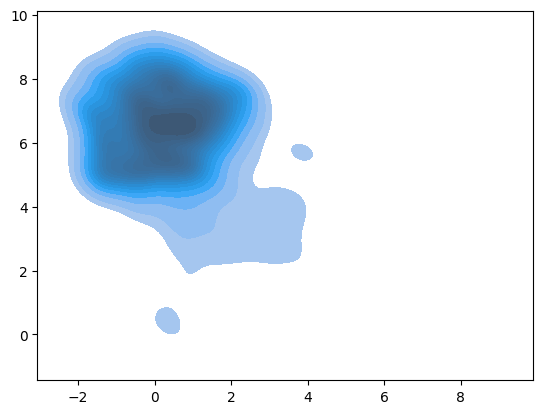

In [33]:
import seaborn as sb
emb = mapper.embedding_[ys==0]
sb.kdeplot(x=emb[:,0], y=emb[:,1], fill=True, levels=20)
plt.show()

emb = mapper.embedding_[ys==1]
sb.kdeplot(x=emb[:,0], y=emb[:,1], fill=True, levels=20)
plt.show()